# Train a category classifer: given the description of the YouTube video and predict which of the six categories it belong to

## Data Prep

In [5]:
import pandas as pd

In [6]:
data_path='./six_cat_train.csv'
df=pd.read_csv(data_path)

In [7]:
category_EN={'1': 'Film & Animation',
 '2': 'Autos & Vehicles',
 '10': 'Music',
 '15': 'Pets & Animals',
 '17': 'Sports',
 '18': 'Short Movies',
 '19': 'Travel & Events',
 '20': 'Gaming',
 '21': 'Videoblogging',
 '22': 'People & Blogs',
 '23': 'Comedy',
 '24': 'Entertainment',
 '25': 'News & Politics',
 '26': 'Howto & Style',
 '27': 'Education',
 '28': 'Science & Technology',
 '30': 'Movies',
 '31': 'Anime/Animation',
 '32': 'Action/Adventure',
 '33': 'Classics',
 '34': 'Comedy',
 '35': 'Documentary',
 '36': 'Drama',
 '37': 'Family',
 '38': 'Foreign',
 '39': 'Horror',
 '40': 'Sci-Fi/Fantasy',
 '41': 'Thriller',
 '42': 'Shorts',
 '43': 'Shows',
 '44': 'Trailers',
 '29': 'Nonprofits & Activism'}

In [8]:
id_train=[24,25,22,10,17,23]
id_train_label={24:0,25:1,22:2,10:3,17:4,23:5}
category_six=[]
for id_ in id_train:
    category_six.append(category_EN[str(id_)])

In [9]:
six_cat_train=df.dropna(subset=['category_id'])

In [10]:
label=[]
for cid in six_cat_train.category_id:
    label.append(id_train_label[cid])

In [11]:
six_cat_train['label']=label

/Users/billyzhaoyh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Split into train and test set

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
#compare if descriptions are better
X_train, X_test, y_train, y_test = train_test_split(six_cat_train.description.tolist(), six_cat_train.label.tolist(), test_size=0.2, random_state=42)

## Use multinomial naive bayes and svm as bench mark algorithms

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
import numpy as np

In [17]:
text_clf_nb = Pipeline([
     ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
])

In [22]:
text_clf_nb.fit(X_train, y_train)
predicted = text_clf_nb.predict(X_test)
np.mean(predicted == y_test)

0.610857432775241

In [23]:
print(metrics.classification_report(y_test, predicted,target_names=category_six))

                 precision    recall  f1-score   support

  Entertainment       0.53      0.99      0.69      1680
News & Politics       0.94      0.37      0.53       568
 People & Blogs       1.00      0.15      0.27       458
          Music       0.98      0.25      0.40       434
         Sports       0.95      0.53      0.68       411
         Comedy       0.96      0.35      0.51       391

       accuracy                           0.61      3942
      macro avg       0.89      0.44      0.51      3942
   weighted avg       0.78      0.61      0.57      3942



In [24]:
text_clf_svm = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None)),
])



In [25]:
text_clf_svm.fit(X_train, y_train)
predicted = text_clf_svm.predict(X_test)
np.mean(predicted == y_test)

0.7886859462201928

In [26]:
print(metrics.classification_report(y_test, predicted,target_names=category_six))

                 precision    recall  f1-score   support

  Entertainment       0.71      0.96      0.82      1680
News & Politics       0.88      0.74      0.80       568
 People & Blogs       0.93      0.33      0.49       458
          Music       0.86      0.83      0.85       434
         Sports       0.90      0.79      0.84       411
         Comedy       0.93      0.62      0.75       391

       accuracy                           0.79      3942
      macro avg       0.87      0.71      0.76      3942
   weighted avg       0.82      0.79      0.78      3942



## Using deep learning to boost the performance (distilbert)

In [2]:
import ktrain
from ktrain import text

In [10]:
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, classes=category_six)
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:367: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: en
train sequence lengths:
	mean : 109
	95percentile : 310
	99percentile : 490


preprocessing test...
language: en
test sequence lengths:
	mean : 108
	95percentile : 306
	99percentile : 515


simulating training for different learning rates... this may take a few moments...
Train for 2627 steps
Epoch 1/2
2627/2627 [==============================] - 1956s 745ms/step - loss: 1.3469 - accuracy: 0.5023
Epoch 2/2
2478/2627 [===========================>..] - ETA: 1:50 - loss: 1.7898 - accuracy: 0.3874

done.
Visually inspect loss plot and select learning rate associated with falling loss


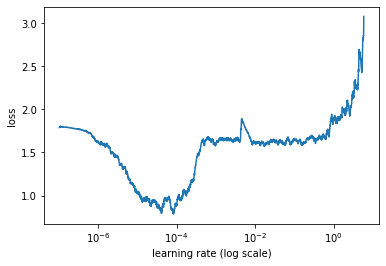

In [28]:
learner.lr_find(show_plot=True,max_epochs=2)

In [11]:
learner.fit_onecycle(1e-4, 4)



begin training using onecycle policy with max lr of 0.0001...
Train for 2628 steps, validate for 124 steps
Epoch 1/4
2628/2628 [==============================] - 2104s 801ms/step - loss: 0.7972 - accuracy: 0.7292 - val_loss: 0.5444 - val_accuracy: 0.8196
Epoch 2/4
2628/2628 [==============================] - 2092s 796ms/step - loss: 0.5138 - accuracy: 0.8315 - val_loss: 0.4996 - val_accuracy: 0.8427
Epoch 3/4
2628/2628 [==============================] - 2091s 796ms/step - loss: 0.3475 - accuracy: 0.8918 - val_loss: 0.4400 - val_accuracy: 0.8590
Epoch 4/4
2628/2628 [==============================] - 2092s 796ms/step - loss: 0.1463 - accuracy: 0.9541 - val_loss: 0.4495 - val_accuracy: 0.8683


In [15]:
learner.validate(class_names=t.get_classes())

                 precision    recall  f1-score   support

  Entertainment       0.87      0.91      0.89      1680
News & Politics       0.91      0.87      0.89       568
 People & Blogs       0.75      0.70      0.72       458
          Music       0.89      0.89      0.89       434
         Sports       0.93      0.88      0.91       411
         Comedy       0.84      0.83      0.84       391

       accuracy                           0.87      3942
      macro avg       0.86      0.85      0.86      3942
   weighted avg       0.87      0.87      0.87      3942



array([[1533,   23,   57,   29,   10,   28],
       [  54,  493,   17,    0,    2,    2],
       [  79,   16,  322,   12,   11,   18],
       [  24,    2,   10,  387,    3,    8],
       [  21,    5,   15,    2,  363,    5],
       [  46,    1,   11,    6,    2,  325]])

In [16]:
learner.view_top_losses(n=1, preproc=t)

----------
id:2730 | loss:9.92 | true:Comedy | pred:Entertainment)



In [17]:
predictor = ktrain.get_predictor(learner.model, preproc=t)
predictor.save('./distilbert')

In [2]:
reloaded_predictor = ktrain.load_predictor('./distilbert')